In [ ]:
# Instala dependências se necessário
import sys
import subprocess

def install_if_missing(package):
    try:
        __import__(package.split('-')[0].split('[')[0])
    except ImportError:
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", package])

# Atualiza typing_extensions primeiro (resolve problema de compatibilidade com pydantic/mlflow)
print("Verificando e atualizando dependências...")
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--quiet", 
                          "typing_extensions>=4.8.0", "pydantic>=2.0.0"])
    print("✅ Dependências atualizadas")
except:
    print("⚠️  Aviso: Algumas dependências podem precisar de atualização manual")

dependencies = [
    'pandas', 'numpy', 'sqlalchemy', 'psycopg2-binary', 'scikit-learn',
    'xgboost', 'mlflow', 'matplotlib', 'seaborn'
]

for dep in dependencies:
    install_if_missing(dep)

import pandas as pd
import numpy as np
import psycopg2
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# MLFlow
import mlflow
import mlflow.sklearn

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Bibliotecas importadas com sucesso!")


Verificando e atualizando dependências...
✅ Dependências atualizadas
Instalando scikit-learn...
✅ Bibliotecas importadas com sucesso!


## 2. Configuração do MLFlow


In [11]:
# Configura MLFlow tracking
# MLFlow está rodando no container 'mlflow' na porta 5000
MLFLOW_TRACKING_URI = "http://mlflow:5000"

try:
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment("intensidade_chuva_classificacao")
    print(f"✅ MLFlow conectado: {MLFLOW_TRACKING_URI}")
    print(f"✅ Experimento: intensidade_chuva_classificacao")
except Exception as e:
    print(f"⚠️  Erro ao conectar MLFlow: {e}")
    print("Continuando sem MLFlow...")


✅ MLFlow conectado: http://mlflow:5000
✅ Experimento: intensidade_chuva_classificacao


## 3. Conexão com PostgreSQL


In [ ]:
# Configurações de conexão
DB_CONFIG = {
    'host': 'postgres',
    'port': 5432,
    'database': 'inmet_db',
    'user': 'inmet_user',
    'password': 'inmet_password'
}

print("✅ Configuração de conexão definida!")


✅ Configuração de conexão definida!


## 4. Carregamento dos Dados Tratados


In [ ]:
# Carrega dados tratados (com intensidade_chuva já classificada)
query = """
SELECT 
    dm.id,
    dm.codigo_wmo,
    dm.timestamp_utc,
    dm.precipitacao_mm,
    dm.intensidade_chuva,
    dm.pressao_estacao_mb,
    dm.pressao_max_mb,
    dm.pressao_min_mb,
    dm.temperatura_ar_c,
    dm.temperatura_max_c,
    dm.temperatura_min_c,
    dm.umidade_rel_horaria_pct,
    dm.umidade_rel_max_pct,
    dm.umidade_rel_min_pct,
    dm.vento_velocidade_ms,
    dm.vento_direcao_graus,
    dm.vento_rajada_max_ms,
    dm.radiacao_global_kjm2,
    EXTRACT(YEAR FROM dm.timestamp_utc) as ano,
    EXTRACT(MONTH FROM dm.timestamp_utc) as mes,
    EXTRACT(DAY FROM dm.timestamp_utc) as dia,
    EXTRACT(HOUR FROM dm.timestamp_utc) as hora,
    EXTRACT(DOW FROM dm.timestamp_utc) as dia_semana
FROM dados_meteorologicos dm
WHERE dm.intensidade_chuva IS NOT NULL
ORDER BY dm.timestamp_utc
"""

# Lê dados usando conexão direta com psycopg2 (evita problemas de encoding)
try:
    conn = psycopg2.connect(
        host=DB_CONFIG['host'],
        port=DB_CONFIG['port'],
        database=DB_CONFIG['database'],
        user=DB_CONFIG['user'],
        password=DB_CONFIG['password']
    )
    conn.set_client_encoding('UTF8')
    df = pd.read_sql(query, conn)
    conn.close()
    
    df['timestamp_utc'] = pd.to_datetime(df['timestamp_utc'])
    print("✅ Dados carregados com sucesso!")
except Exception as e:
    print(f"❌ Erro ao carregar dados: {e}")
    df = pd.DataFrame()

if len(df) == 0:
    print("\n⚠️  ATENÇÃO: Nenhum dado encontrado no banco!")
    print("\nExecute primeiro o notebook 02_tratamento_limpeza.ipynb")
else:
    print(f"Dados carregados: {len(df):,} registros")
    print(f"Período: {df['timestamp_utc'].min()} até {df['timestamp_utc'].max()}")
    print(f"\nDistribuição de classes:")
    display(df['intensidade_chuva'].value_counts())
    print(f"\nShape: {df.shape}")
    display(df.head())


✅ Dados carregados com sucesso!
Dados carregados: 96,480 registros
Período: 2024-01-01 00:00:00 até 2025-10-31 23:00:00

Distribuição de classes:


intensidade_chuva
sem_chuva    93133
leve          2855
moderada       428
forte           64
Name: count, dtype: int64


Shape: (96480, 23)


,id,codigo_wmo,timestamp_utc,precipitacao_mm,intensidade_chuva,pressao_estacao_mb,pressao_max_mb,pressao_min_mb,temperatura_ar_c,temperatura_max_c,...,umidade_rel_min_pct,vento_velocidade_ms,vento_direcao_graus,vento_rajada_max_ms,radiacao_global_kjm2,ano,mes,dia,hora,dia_semana
0,8785,A366,2024-01-01,0.0,sem_chuva,960.8,960.8,960.4,26.4,27.2,...,64.0,1.9,253.0,7.0,NaN,2024.0,1.0,1.0,0.0,1.0
1,1,A357,2024-01-01,0.0,sem_chuva,993.9,993.9,993.3,25.5,25.8,...,84.0,1.2,32.0,2.8,NaN,2024.0,1.0,1.0,0.0,1.0
2,48241,A322,2024-01-01,NaN,sem_chuva,922.1,922.1,921.4,22.2,22.2,...,NaN,3.5,64.0,6.8,NaN,2024.0,1.0,1.0,0.0,1.0
3,57025,A350,2024-01-01,0.8,leve,956.2,956.5,955.9,22.7,24.1,...,74.0,1.1,64.0,4.9,39.8,2024.0,1.0,1.0,0.0,1.0
4,17569,A328,2024-01-01,NaN,sem_chuva,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024.0,1.0,1.0,0.0,1.0


In [14]:
if len(df) > 0:
    # Remove valores faltantes restantes
    df = df.dropna()
    
    # Seleciona features para modelagem
    feature_cols = [
        'precipitacao_mm',
        'pressao_estacao_mb', 'pressao_max_mb', 'pressao_min_mb',
        'temperatura_ar_c', 'temperatura_max_c', 'temperatura_min_c',
        'umidade_rel_horaria_pct', 'umidade_rel_max_pct', 'umidade_rel_min_pct',
        'vento_velocidade_ms', 'vento_direcao_graus', 'vento_rajada_max_ms',
        'radiacao_global_kjm2',
        'ano', 'mes', 'dia', 'hora', 'dia_semana'
    ]
    
    # Remove colunas que não existem no dataframe
    feature_cols = [col for col in feature_cols if col in df.columns]
    
    # Prepara X (features) e y (target)
    X = df[feature_cols].copy()
    y = df['intensidade_chuva'].copy()
    
    # Codifica variável target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Mapeia classes para referência
    class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("Mapeamento de classes:")
    for classe, codigo in class_mapping.items():
        print(f"  {classe}: {codigo}")
    
    print(f"\nFeatures selecionadas: {len(feature_cols)}")
    print(f"Shape X: {X.shape}")
    print(f"Shape y: {y_encoded.shape}")
    print(f"\nDistribuição de classes:")
    display(pd.Series(y).value_counts())
else:
    print("⚠️  Nenhum dado disponível para modelagem!")


Mapeamento de classes:
  forte: 0
  leve: 1
  moderada: 2
  sem_chuva: 3

Features selecionadas: 19
Shape X: (25844, 19)
Shape y: (25844,)

Distribuição de classes:


intensidade_chuva
sem_chuva    24708
leve           959
moderada       149
forte           28
Name: count, dtype: int64

In [15]:
if len(df) > 0:
    # Divide em treino e teste (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    # Normaliza features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"✅ Divisão treino/teste concluída!")
    print(f"Treino: {X_train.shape[0]:,} amostras")
    print(f"Teste: {X_test.shape[0]:,} amostras")
    print(f"\nDistribuição de classes no treino:")
    display(pd.Series(y_train).value_counts().sort_index())
    print(f"\nDistribuição de classes no teste:")
    display(pd.Series(y_test).value_counts().sort_index())
else:
    print("⚠️  Nenhum dado disponível!")


✅ Divisão treino/teste concluída!
Treino: 20,675 amostras
Teste: 5,169 amostras

Distribuição de classes no treino:


0       23
1      767
2      119
3    19766
Name: count, dtype: int64


Distribuição de classes no teste:


0       5
1     192
2      30
3    4942
Name: count, dtype: int64

## 7. Função de Avaliação


In [16]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Avalia modelo e retorna métricas"""
    # Treina modelo
    model.fit(X_train, y_train)
    
    # Predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    metrics = {
        'model_name': model_name,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'cv_accuracy_mean': cv_mean,
        'cv_accuracy_std': cv_std
    }
    
    return model, metrics, y_test_pred

print("✅ Função de avaliação definida!")


✅ Função de avaliação definida!


## 8. Treinamento de Modelos com MLFlow


In [17]:
if len(df) > 0:
    # Define modelos a testar
    models = {
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
    }
    
    # Tenta adicionar XGBoost se disponível
    try:
        import xgboost as xgb
        models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    except ImportError:
        print("⚠️  XGBoost não disponível, pulando...")
    
    # Dicionário para armazenar resultados
    results = {}
    
    # Treina cada modelo
    for model_name, model in models.items():
        print(f"\n{'='*60}")
        print(f"Treinando {model_name}...")
        print(f"{'='*60}")
        
        try:
            with mlflow.start_run(run_name=model_name):
                # Treina e avalia
                trained_model, metrics, predictions = evaluate_model(
                    model, X_train_scaled, X_test_scaled, y_train, y_test, model_name
                )
                
                # Loga parâmetros
                mlflow.log_params(model.get_params())
                
                # Loga métricas
                for metric_name, metric_value in metrics.items():
                    if isinstance(metric_value, (int, float)):
                        mlflow.log_metric(metric_name, metric_value)
                
                # Loga modelo (tenta salvar, mas continua mesmo se falhar)
                try:
                    mlflow.sklearn.log_model(
                        sk_model=trained_model, 
                        artifact_path="model",
                        registered_model_name=f"{model_name}_intensidade_chuva"
                    )
                    print("✅ Modelo salvo no MLFlow")
                except Exception as model_error:
                    # Tenta método alternativo sem registro
                    try:
                        mlflow.sklearn.log_model(
                            sk_model=trained_model, 
                            artifact_path="model"
                        )
                        print("✅ Modelo salvo no MLFlow (sem registro)")
                    except:
                        print(f"⚠️  Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)")
                        print(f"   Erro: {str(model_error)[:100]}")
                
                # Salva resultados
                results[model_name] = {
                    'model': trained_model,
                    'metrics': metrics,
                    'predictions': predictions
                }
                
                print(f"Accuracy (Treino): {metrics['train_accuracy']:.4f}")
                print(f"Accuracy (Teste): {metrics['test_accuracy']:.4f}")
                print(f"F1-Score (Teste): {metrics['test_f1']:.4f}")
                print(f"CV Accuracy: {metrics['cv_accuracy_mean']:.4f} (+/- {metrics['cv_accuracy_std']:.4f})")
                
        except Exception as e:
            print(f"❌ Erro ao treinar {model_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"\n{'='*60}")
    print("✅ Treinamento concluído!")
    print(f"{'='*60}")
    
    # Compara modelos
    if results:
        print("\nComparação de Modelos:")
        comparison_df = pd.DataFrame([r['metrics'] for r in results.values()])
        display(comparison_df[['model_name', 'test_accuracy', 'test_f1', 'cv_accuracy_mean']].sort_values('test_accuracy', ascending=False))
else:
    print("⚠️  Nenhum dado disponível para treinamento!")



Treinando RandomForest...


2025/11/30 02:50:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/30 02:50:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


⚠️  Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 1.0000
Accuracy (Teste): 0.9992
F1-Score (Teste): 0.9992
CV Accuracy: 0.9986 (+/- 0.0004)
🏃 View run RandomForest at: http://mlflow:5000/#/experiments/1/runs/22198b1750714c19be73d60c52c60840
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinando GradientBoosting...


2025/11/30 02:51:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/30 02:51:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


⚠️  Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 1.0000
Accuracy (Teste): 1.0000
F1-Score (Teste): 1.0000
CV Accuracy: 1.0000 (+/- 0.0001)
🏃 View run GradientBoosting at: http://mlflow:5000/#/experiments/1/runs/c3529c7b466d4ebc813b195bca380e1d
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinando LogisticRegression...


2025/11/30 02:51:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/30 02:51:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


⚠️  Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 0.9992
Accuracy (Teste): 0.9990
F1-Score (Teste): 0.9991
CV Accuracy: 0.9985 (+/- 0.0006)
🏃 View run LogisticRegression at: http://mlflow:5000/#/experiments/1/runs/51b689791726499cbeaba35e400cb82a
🧪 View experiment at: http://mlflow:5000/#/experiments/1

Treinando XGBoost...


2025/11/30 02:51:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/30 02:51:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


⚠️  Aviso: Modelo não foi salvo no MLFlow (métricas foram registradas)
   Erro: API request to endpoint /api/2.0/mlflow/logged-models failed with error code 404 != 200. Response bo
Accuracy (Treino): 1.0000
Accuracy (Teste): 1.0000
F1-Score (Teste): 1.0000
CV Accuracy: 1.0000 (+/- 0.0001)
🏃 View run XGBoost at: http://mlflow:5000/#/experiments/1/runs/0ccf0c9b59b94649b31b3ed78fcf8f5c
🧪 View experiment at: http://mlflow:5000/#/experiments/1

✅ Treinamento concluído!

Comparação de Modelos:


,model_name,test_accuracy,test_f1,cv_accuracy_mean
1,GradientBoosting,1.000000,1.000000,0.999952
3,XGBoost,1.000000,1.000000,0.999952
0,RandomForest,0.999226,0.999179,0.998646
2,LogisticRegression,0.999033,0.999051,0.998501


Melhor modelo: GradientBoosting
Accuracy: 1.0000


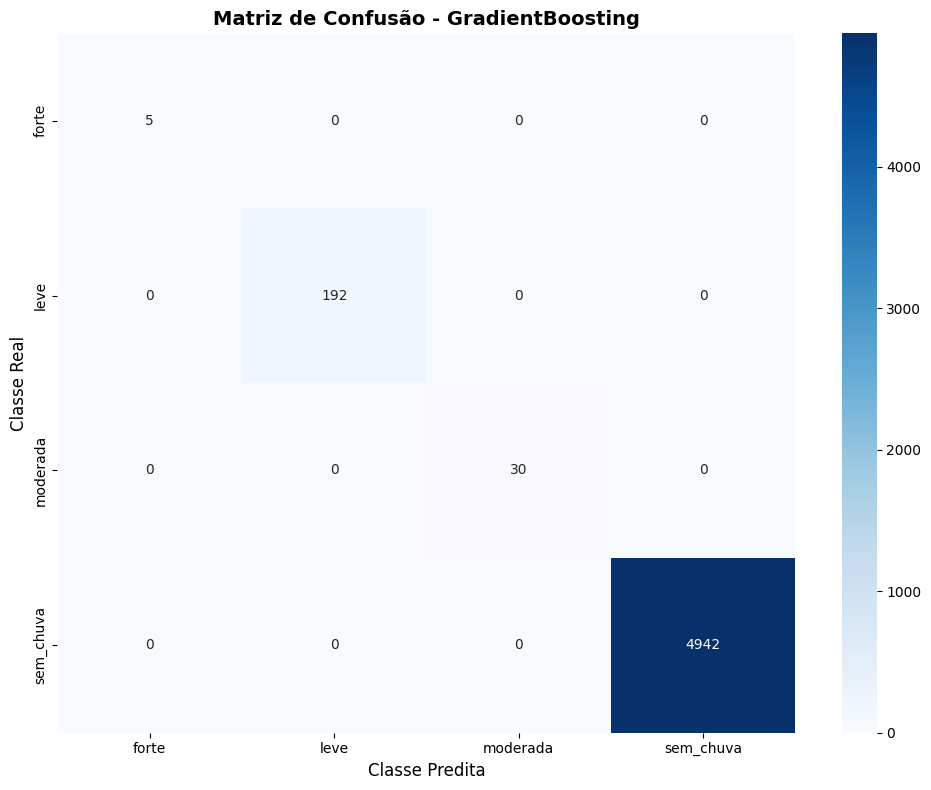


Relatório de Classificação:
              precision    recall  f1-score   support

       forte       1.00      1.00      1.00         5
        leve       1.00      1.00      1.00       192
    moderada       1.00      1.00      1.00        30
   sem_chuva       1.00      1.00      1.00      4942

    accuracy                           1.00      5169
   macro avg       1.00      1.00      1.00      5169
weighted avg       1.00      1.00      1.00      5169



In [18]:
if len(df) > 0 and results:
    # Seleciona melhor modelo
    best_model_name = max(results.keys(), key=lambda k: results[k]['metrics']['test_accuracy'])
    best_model = results[best_model_name]
    
    print(f"Melhor modelo: {best_model_name}")
    print(f"Accuracy: {best_model['metrics']['test_accuracy']:.4f}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, best_model['predictions'])
    
    # Visualização
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Classe Real', fontsize=12)
    plt.xlabel('Classe Predita', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Relatório de classificação
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, best_model['predictions'], target_names=le.classes_))
else:
    print("⚠️  Nenhum modelo treinado disponível!")


## 10. Resumo Final


In [19]:
print("="*80)
print("RESUMO DA MODELAGEM")
print("="*80)

if len(df) > 0 and results:
    print(f"\n✅ Modelos treinados: {len(results)}")
    print(f"✅ Total de registros: {len(df):,}")
    print(f"✅ Features utilizadas: {len(feature_cols)}")
    
    print(f"\n📊 Acesse o MLFlow em: http://localhost:5000")
    print(f"   Experimento: intensidade_chuva_classificacao")
    
    print(f"\n📈 Próximos passos:")
    print(f"   1. Analisar resultados no MLFlow")
    print(f"   2. Executar notebook 04_preparacao_visualizacao.ipynb")
    print(f"   3. Criar dashboards no Trendz")
else:
    print("\n⚠️  Execute primeiro os notebooks anteriores!")

print("\n" + "="*80)


RESUMO DA MODELAGEM

✅ Modelos treinados: 4
✅ Total de registros: 25,844
✅ Features utilizadas: 19

📊 Acesse o MLFlow em: http://localhost:5000
   Experimento: intensidade_chuva_classificacao

📈 Próximos passos:
   1. Analisar resultados no MLFlow
   2. Executar notebook 04_preparacao_visualizacao.ipynb
   3. Criar dashboards no Trendz

